how to implement the image captioning model using Convolutional Neural Networks (CNNs) and Long Short-Term Memory (LSTM) step by step practically

In [ ]:
!pip install -qU openimages torch_snippets urllib3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.8/202.8 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 11.4 MB/s eta 0

1. Fetch the dataset from the Open Images dataset, which includes training images, their annotations, and the
validation dataset:

In [ ]:
import requests

url = 'https://storage.googleapis.com/localized-narratives/annotations/open_images_train_v6_captions.jsonl'
response = requests.get(url)

with open('open_images_train_captions.jsonl', 'wb') as f:
    f.write(response.content)


In [ ]:
!pip install lovely-tensors

In [ ]:
# Import the relevant packages, define the device
from torch_snippets import *
import json
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Running on device: ", device)


Running on device:  cuda

In [ ]:
with open('open_images_train_captions.jsonl', 'r') as json_file:
    # rest of the code goes here
    json_list = json_file.read().split('\n')
    np.random.shuffle(json_list)
    data = []
    N = 100000
    for ix, json_str in Tqdm(enumerate(json_list), N):
        if ix == N: break
    try:
        result = json.loads(json_str)
        x = pd.DataFrame.from_dict(result, orient='index').T
        data.append(x)
    except:
        pass


100%|██████████| 100000/100000 [00:00<00:00, 2288967.47it/s]


In [ ]:
result

{'dataset_id': 'open_images',
 'image_id': '6cb4cfb543fa0c8e',
 'annotator_id': 43,
 'caption': 'In this image we can see a lady with a costume. She is dancing. In the background it is blur. And we can see many people. Also there is a person playing a guitar on the right side. And there are lights.'}

In [ ]:
# Split the dataframe (data) into training and validation datasets
np.random.seed(10)

data = pd.concat(data)
data['train'] = np.random.choice([True,False], size=len(data),p=[0.95,0.05])
data.to_csv('data.csv', index=False)

In [ ]:
!mkdir -p train-images val-images

In [ ]:
# Download the images corresponding to the image IDs fetched from the JSON file:
from openimages.download import _download_images_by_id

subset_imageIds = data[data['train']].image_id.tolist()
_download_images_by_id(subset_imageIds, 'train', './train-images/')

subset_imageIds = data[~data['train']].image_id.tolist()
_download_images_by_id(subset_imageIds, 'train', './val-images/')


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
0it [00:00, ?it/s]


2. Create a vocabulary of all the unique words present in all the captions in the dataframe:

In [ ]:
!pip install torchtext

In [ ]:
!pip install --upgrade torchtext

In [ ]:
!pip install matplotlib-venn

In [ ]:
!apt-get -qq install -y libfluidsynth1

E: Package 'libfluidsynth1' has no installation candidate


In [ ]:
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive

Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 123105 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.4.0-2ubuntu1.2_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.4.0-2ubuntu1.2) ...
Setting up libarchive-dev:amd64 (3.4.0-2ubuntu1.2) ...
Processing triggers for man-db (2.9.1-1) ...
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 8.8 MB/s eta 0:00:00
  Created wheel for libarchive: filename=libarchive-0.4.7-py3-none-any.whl size=31629 sha256=3b1b9faa56b3588df4668c0fbf3d0ab45fbe5ea7f5d9a7d9eb7208d72fa02a9f
  Stored in directory: /root/.cache/pip/wheels/3a/94/d0/6cd83c8a80a4236fd4cb2a1fd846ecf72ab1e0ac238c5951c0
Successfully built libarchive


In [ ]:
!apt-get -qq install -y graphviz

In [ ]:
!pip install pydot

In [ ]:
!apt-get -qq install -y graphviz && pip install pydot
import pydot

In [ ]:
!pip install cartopy
import cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 57.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 5.1 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp310-cp310-linux_x86_64.whl size=11102754 sha256=66343888bc210301cce9a661f9333cee2c32ea1546ea0eba3b79f124f25aa699
  Stored in directory: /root/.cache/pip/wheels/30/b0/1a/1c1909e00c76653dc4e2ff48555257c0eb2d1698280c8d9955
Successfully built cartopy


In [ ]:
!pip install torchtext==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.6 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.2
    Uninstalling torchtext-0.15.2:
      Successfully uninstalled torchtext-0.15.2


In [ ]:
with open('open_images_train_captions.jsonl', 'r') as json_file:
    json_list = json_file.read().split('\n')

np.random.shuffle(json_list)
data = []
N = 10000 # Doing 10000 instead of 100000 because cuda runs out of memory

for ix, json_str in Tqdm(enumerate(json_list), N):
    if ix == N: break
    try:
        result = json.loads(json_str)
        x = pd.DataFrame.from_dict(result, orient='index').T
        data.append(x)
    except:
        pass


100%|██████████| 10000/10000 [00:04<00:00, 2138.62it/s]


In [ ]:
# Split the dataframe (data) into training and validation datasets
np.random.seed(10)

data = pd.concat(data)
data['train'] = np.random.choice([True,False], size=len(data),p=[0.95,0.05])
data.to_csv('data.csv', index=False)

In [ ]:
# Download the images corresponding to the image IDs fetched from the JSON file:
from openimages.download import _download_images_by_id

subset_imageIds = data[data['train']].image_id.tolist()
_download_images_by_id(subset_imageIds, 'train', './train-images/')

subset_imageIds = data[~data['train']].image_id.tolist()
_download_images_by_id(subset_imageIds, 'train', './val-images/')


100%|██████████| 470/470 [00:12<00:00, 36.82it/s]


In [ ]:
!pip install pycocotools

2. Create a vocabulary of all the unique words present in all the captions in the dataframe:

In [ ]:
# A vocabulary object is something that can map every word in all the captions to a unique integer and vice versa
from torchtext.data import Field
from pycocotools.coco import COCO
from collections import defaultdict
captions = Field(sequential=False, init_token='', eos_token='')

all_captions = data[data['train']]['caption'].tolist()
all_tokens = [[w.lower() for w in c.split()] for c in all_captions]
all_tokens = [w for sublist in all_tokens for w in sublist]

captions.build_vocab(all_tokens)


In [ ]:
captions = Field(sequential=False, init_token='', eos_token='')

all_captions = data[data['train']]['caption'].tolist()
all_tokens = [[w.lower() for w in c.split()] for c in all_captions]
all_tokens = [w for sublist in all_tokens for w in sublist]

captions.build_vocab(all_tokens)

In [ ]:
# Captions vocabulary components
class Vocab: pass

vocab = Vocab()
captions.vocab.itos.insert(0, '')
vocab.itos = captions.vocab.itos

vocab.stoi = defaultdict(lambda:captions.vocab.itos.index(''))
vocab.stoi[''] = 0

for s,i in captions.vocab.stoi.items():
    vocab.stoi[s] = i+1


3. Define the dataset class – CaptioningDataset:


In [ ]:
# Dataset class
from torchvision import transforms

class CaptioningData(Dataset):
    def __init__(self, root, df, vocab):
        self.df = df.reset_index(drop=True)
        self.root = root
        self.vocab = vocab

        self.transform = transforms.Compose([
            transforms.Resize(224),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
        )

    # Returns one data pair (image and caption)
    def __getitem__(self, index):
        row = self.df.iloc[index].squeeze()
        id = row.image_id

        image_path = f'{self.root}/{id}.jpg'
        image = Image.open(os.path.join(image_path)).convert('RGB')

        caption = row.caption

        tokens = str(caption).lower().split()
        target = []
        target.append(vocab.stoi[''])
        target.extend([vocab.stoi[token] for token in tokens])
        target.append(vocab.stoi[''])
        target = torch.Tensor(target).long()

        return image, target, caption

    def choose(self):
        return self[np.random.randint(len(self))]

    def __len__(self):
        return len(self.df)

    # Creates batch of captions and padds captions to be equal length
    def collate_fn(self, data):
        data.sort(key=lambda x: len(x[1]), reverse=True)
        images, targets, captions = zip(*data)
        images = torch.stack([self.transform(image) for image in images], 0)

        lengths = [len(tar) for tar in targets]
        _targets = torch.zeros(len(captions), max(lengths)).long()

        for i, tar in enumerate(targets):
            end = lengths[i]
            _targets[i, :end] = tar[:end]

        return images.to(device), _targets.to(device), torch.tensor(lengths).long().to(device)


4. Define the training and validation dataset and data loaders:


In [ ]:
#Define the training and validation dataset and data loaders
trn_ds = CaptioningData('train-images', data[data['train']], vocab)

val_ds = CaptioningData('val-images', data[~data['train']], vocab)

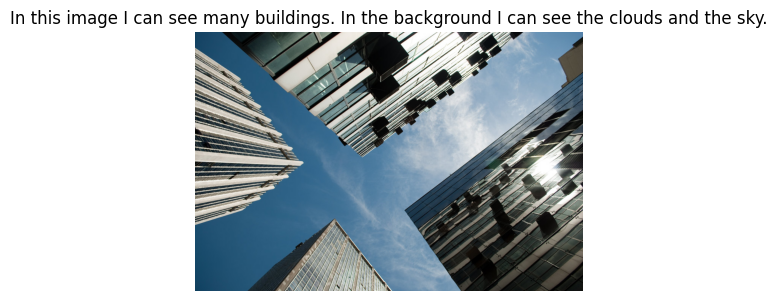

tensor[21] i64 x∈[2, 190] μ=27.905 σ=49.671

In [ ]:
# Show sample image and caption
image, target, caption = trn_ds.choose()
show(image, title=caption, sz=5); print(target)


5. Create the dataloaders for the datasets:


In [ ]:
# Create the dataloaders for the datasets
trn_dl = DataLoader(trn_ds, 32, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, collate_fn=val_ds.collate_fn)

In [ ]:
!pip install torch

In [ ]:
import torch as torch

In [ ]:
!pip install torch

In [ ]:
inspect(*next(iter(trn_dl)), names='images,targets,lengths')

══════════════════════════════════════════════════════════════════

tensor[32, 3, 224, 224] n=4816896 (18Mb) x∈[-2.118, 2.640] μ=-0.072 σ=1.223 cuda:0

══════════════════════════════════════════════════════════════════

tensor[32, 96] i64 n=3072 (24Kb) x∈[0, 4868] μ=60.541 σ=294.794 cuda:0

══════════════════════════════════════════════════════════════════

tensor[32] i64 x∈[16, 96] μ=38.719 σ=18.058 cuda:0

══════════════════════════════════════════════════════════════════

6. Define the network class:


In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import models

In [ ]:
# The network class - EncoderCNN
class EncoderCNN(nn.Module):

    # Load the pretrained ResNet-nn152 and replace top fc layer
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)

        # Felete the last fc layer.
        modules = list(resnet.children())[:-1]

        # Connect it to a linear layer
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)

        # Pass it through batch normalization
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    # Extract feature vectors from input images
    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)

        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))

        return features

In [ ]:
# Creating encoder instance
encoder = EncoderCNN(256).to(device)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:00<00:00, 259MB/s]


In [ ]:
!pip install torch_summary
from torchsummary import summary
print(summary(encoder,torch.zeros(32,3,224,224).to(device)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2048, 1, 1]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 256, 56, 56]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 56, 56]         75,008
|    |    └─Bottleneck: 3-2              [-1, 256, 56, 56]         70,400
|    |    └─Bottleneck: 3-3              [-1, 256, 56, 56]         70,400
|    └─Sequential: 2-6                   [-1, 512, 28, 28]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 28, 28]         379,392
|    |    └─Bottleneck: 3-5              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-6              [-1, 512, 28, 28] 

==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
├─Sequential: 1-1                        [-1, 2048, 1, 1]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 256, 56, 56]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 56, 56]         75,008
|    |    └─Bottleneck: 3-2              [-1, 256, 56, 56]         70,400
|    |    └─Bottleneck: 3-3              [-1, 256, 56, 56]         70,400
|    └─Sequential: 2-6                   [-1, 512, 28, 28]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 28, 28]         379,392
|    |    └─Bottleneck: 3-5              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-6              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-7              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-8              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-9              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-10             [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-11             [-1, 512, 28, 28]         280,064
|    └─Sequential: 2-7                   [-1, 1024, 14, 14]        --
|    |    └─Bottleneck: 3-12             [-1, 1024, 14, 14]        1,512,448
|    |    └─Bottleneck: 3-13             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-14             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-15             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-16             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-17             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-18             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-19             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-20             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-21             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-22             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-23             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-24             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-25             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-26             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-27             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-28             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-29             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-30             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-31             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-32             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-33             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-34             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-35             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-36             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-37             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-38             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-39             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-40             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-41             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-42             [-1, 1

In [ ]:
# Define the decoder architecture – DecoderRNN
class DecoderRNN(nn.Module):

    # Set the hyper-parameters and build the layers
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=80):

        super(DecoderRNN, self).__init__()

        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length

    # Decode image feature vectors and generates captions
    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)

        packed = pack_padded_sequence(embeddings, lengths.cpu(), batch_first=True)

        outputs, _ = self.lstm(packed)
        outputs = self.linear(outputs[0])
        return outputs

    #Generate captions for given image features using greedy search
    def predict(self, features, states=None):
        sampled_ids = []
        inputs = features.unsqueeze(1)

        for i in range(self.max_seq_length):
            hiddens, states = self.lstm(inputs, states) # hiddens: (batch_size, 1, hidden_size)

            outputs = self.linear(hiddens.squeeze(1)) # outputs: (batch_size, vocab_size)
            _, predicted = outputs.max(1) # predicted: (batch_size)

            sampled_ids.append(predicted)

            inputs = self.embed(predicted) # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1) # inputs: (batch_size, 1, embed_size)


        sampled_ids = torch.stack(sampled_ids, 1) # sampled_ids: (batch_size, max_seq_length)

        # convert predicted tokens to strings
        sentences = []
        for sampled_id in sampled_ids:
            sampled_id = sampled_id.cpu().numpy()
            sampled_caption = []

            for word_id in sampled_id:
                word = vocab.itos[word_id]
                sampled_caption.append(word)

                if word == '<end>':
                    break

            sentence = ' '.join(sampled_caption)
            sentences.append(sentence)

        return sentences


7. Define the functions to train on a batch of data:


In [ ]:
# Trains on a single batch of data
def train_batch(data, encoder, decoder, optimizer, criterion):
    encoder.train()
    decoder.train()

    images, captions, lengths = data
    images = images.to(device)

    captions = captions.to(device)
    targets = pack_padded_sequence(captions, lengths.cpu(), batch_first=True)[0]   ##check here

    features = encoder(images)
    outputs = decoder(features, captions, lengths)
    loss = criterion(outputs, targets)

    decoder.zero_grad()
    encoder.zero_grad()
    loss.backward()
    optimizer.step()

    return loss


8. Define the function to validate on a batch of data:


In [ ]:
# Validate on a batch of data
@torch.no_grad()
def validate_batch(data, encoder, decoder, criterion):
    encoder.eval()
    decoder.eval()

    images, captions, lengths = data
    images = images.to(device)

    captions = captions.to(device)
    targets = pack_padded_sequence(captions, lengths.cpu(), batch_first=True)[0]

    features = encoder(images)
    outputs = decoder(features, captions, lengths)

    loss = criterion(outputs, targets)
    return loss


9. Define the model objects and the loss function, and optimizer:


In [ ]:
# Define encoder, decoder, loss function, and optimizer
encoder = EncoderCNN(256).to(device)
decoder = DecoderRNN(256, 512, len(vocab.itos), 1).to(device)
criterion = nn.CrossEntropyLoss()

params = list(decoder.parameters()) + \
         list(encoder.linear.parameters()) + \
         list(encoder.bn.parameters())

optimizer = torch.optim.AdamW(params, lr=1e-3)

n_epochs = 5 # Doing 5 instead of 10 because training on CPU
log = Report(n_epochs)


10. Train the model over increasing epochs:


EPOCH: 1.000  trn_loss: 3.309  val_loss: 2.672  (332.80s - 1331.22s remaining)
EPOCH: 2.000  trn_loss: 2.491  val_loss: 2.454  (647.30s - 970.96s remaining)
EPOCH: 3.000  trn_loss: 2.267  val_loss: 2.334  (963.08s - 642.05s remaining)
EPOCH: 4.000  trn_loss: 2.108  val_loss: 2.291  (1272.05s - 318.01s remaining)
EPOCH: 5.000  trn_loss: 2.074  val_loss: 2.285  (1584.09s - 0.00s remaining)


100%|██████████| 106/106 [00:00<00:00, 3324.33it/s]


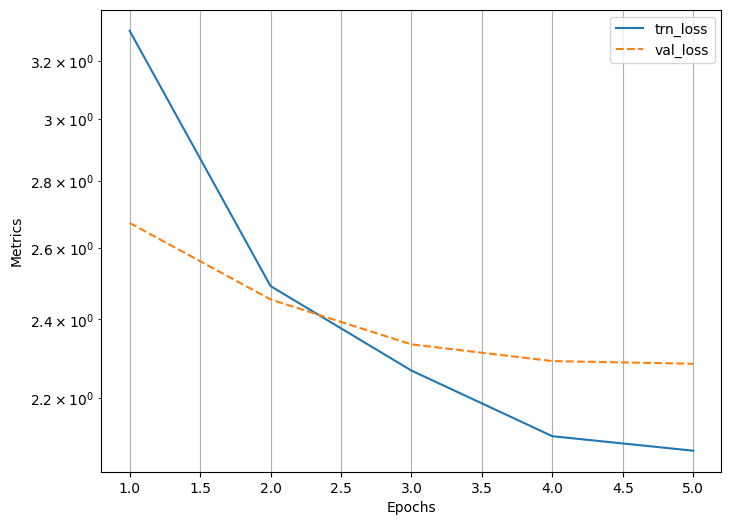

In [ ]:
# Train the model over increasing epochs
for epoch in range(n_epochs):
    if epoch == 3: optimizer = torch.optim.AdamW(params, lr=1e-4)

    N = len(trn_dl)
    for i, data in enumerate(trn_dl):
        trn_loss = train_batch(data, encoder, decoder, optimizer, criterion)
        pos = epoch + (1+i)/N
        log.record(pos=pos, trn_loss=trn_loss, end='\r')

    N = len(val_dl)

    for i, data in enumerate(val_dl):
        val_loss = validate_batch(data, encoder, decoder, criterion)
        pos = epoch + (1+i)/N
        log.record(pos=pos, val_loss=val_loss, end='\r')

    log.report_avgs(epoch+1)

log.plot_epochs(log=True)

11. Define a function that generates predictions given an image:


In [ ]:
#Generates predictions given an image
def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)

    if transform is not None:
        tfm_image = transform(image)[None]

    return image, tfm_image

In [ ]:
def load_image_and_predict(image_path):
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                                    ])

    org_image, tfm_image = load_image(image_path, transform)
    image_tensor = tfm_image.to(device)

    encoder.eval()
    decoder.eval()

    feature = encoder(image_tensor)
    sentence = decoder.predict(feature)[0]

    show(org_image, title=sentence)
    return sentence


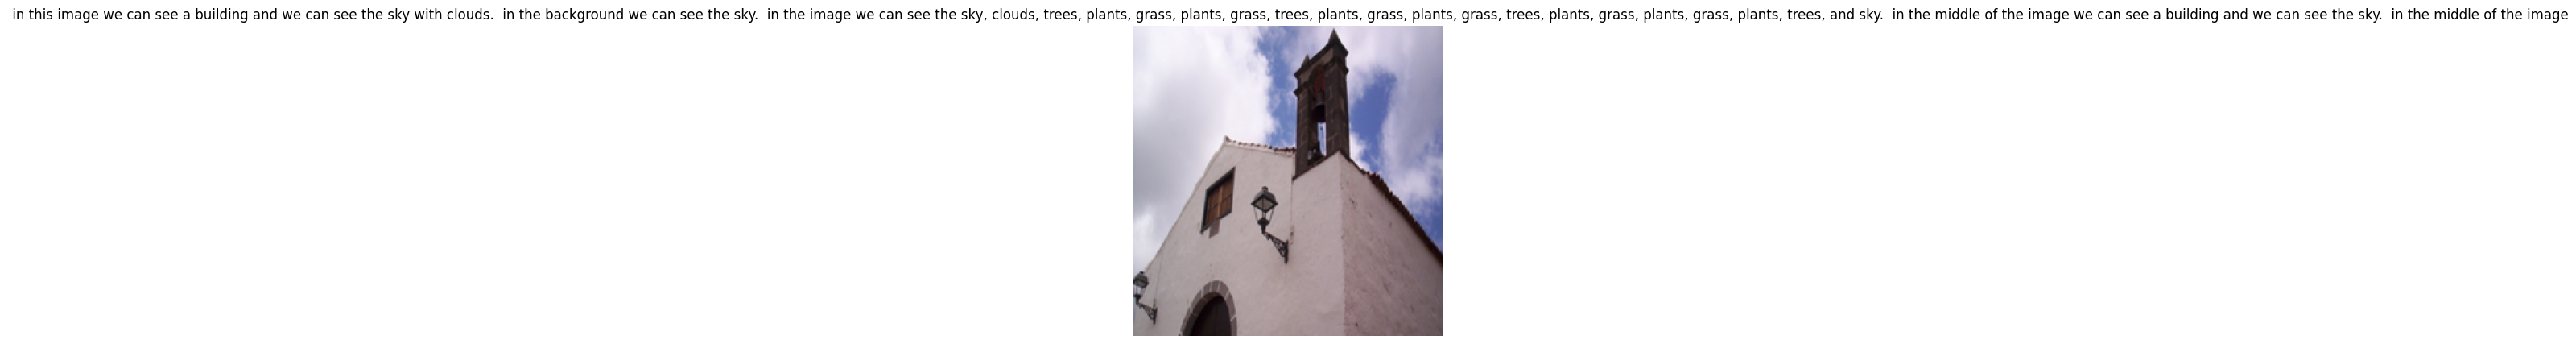

' in this image we can see a building and we can see the sky with clouds.  in the background we can see the sky.  in the image we can see the sky, clouds, trees, plants, grass, plants, grass, trees, plants, grass, plants, grass, trees, plants, grass, plants, grass, plants, trees, and sky.  in the middle of the image we can see a building and we can see the sky.  in the middle of the image'

In [ ]:
# Predict an image
files = Glob('val-images')
load_image_and_predict(choose(files))